<a href="https://colab.research.google.com/github/kilarson/msa/blob/main/msa_cigale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PHANGS Multiscale stellar associaions pipeline: test

Author: Kirsten Larson (kilarson@stsci.edu), ESA/STScI

Date: Aug. 7, 2025

Using the galaxy NGC 4826 as an example. Testing the cigale step of our msa pipeline




In [1]:
# Import standard data analysis packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Import system/command line packages
import os
from os import path # file management
import sys
import shutil
import time # used to track code runtimes
from datetime import date # used to track date code was run

#Import scipy packages
from scipy import ndimage as ndi
from scipy import stats

# KL: Import astropy packages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.table import Table

# JWL: Import other packages
from math import log10, floor
from shlex import split # used to parse command line inputs
import socket # used to get computer hostname

# JWL: Import CIGALE packages
#import pcigale
#from pcigale.analysis_modules.pdf_analysis import PdfAnalysis

In [2]:
def conv_mjy2ab_mag(flux):

    """conversion of mJy to AB mag.
    See definition on Wikipedia : https://en.wikipedia.org/wiki/AB_magnitude """

    return -2.5 * np.log10(flux * 1e-3) + 8.90


def conv_ab_mag2mjy(mag):

    """conversion of AB mag to mJy.
    See definition on Wikipedia : https://en.wikipedia.org/wiki/AB_magnitude """

    return 1e3 * 10 ** ((8.5 - mag)/2.5)

In [20]:
def conv_vega_mag2ab(vega_mag,filter):
  google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
  file_path = google_dir+'header_info_ngc4826_prime.txt'
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
  filter_list = header_info['filter']
  ab_zp = header_info['zpAB']
  vega_zp = header_info['zpVEGA']

  #filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
  #ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
  #vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

  ab_mag = vega_mag - (vega_zp[filter_list.tolist().index(filter)] - ab_zp[filter_list.tolist().index(filter)])
  return ab_mag


In [16]:
def conv_ab_mag2vega(ab_mag,filter):
  #filter_list = ['F275W', 'F336W', 'F435W', 'F438W', 'F555W', 'F814W']
  google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
  file_path = google_dir+'header_info_ngc4826_prime.txt'
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
  filter_list = header_info['filter']
  ab_zp = header_info['zpAB']
  vega_zp = header_info['zpVEGA']

  #filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
  #ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
  #vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

  # convert Series to list before using index()
  vega_mag = ab_mag + (vega_zp[filter_list.tolist().index(filter)] - ab_zp[filter_list.tolist().index(filter)])
  return vega_mag

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Now you can access files in your Google Drive, for example:
# import pandas as pd
google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
# display(df.head())

Mounted at /content/drive


In [6]:
file_path_reg = google_dir+'reg_ha_paa_ebv_nii0p8_iter20250409Masked.fits'
file_path_source =google_dir+'reg_source_base_corrected_nii0p8_4sig_itersub_hole0sigMask.fits'
#df = pd.read_csv(file_path)


#open data file from Chris
#region based extinction correctoin
hdu_list_reg = fits.open(file_path_reg)
hdu_list_reg.info()
# You can access data from specific HDUs like this:
header_reg = hdu_list_reg[1].header
data_reg = hdu_list_reg[1].data
hdu_list_reg.close()



Filename: /content/drive/My Drive/PHANGS/NGC4826/reg_ha_paa_ebv_nii0p8_iter20250409Masked.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    108   454R x 45C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D]   


In [7]:
#Source based extinction correctoin
hdu_list_source = fits.open(file_path_source)
hdu_list_source.info()
# You can access data from specific HDUs like this:
header_source = hdu_list_source[1].header
data_source = hdu_list_source[1].data
hdu_list_source.close()

Filename: /content/drive/My Drive/PHANGS/NGC4826/reg_source_base_corrected_nii0p8_4sig_itersub_hole0sigMask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     82   454R x 37C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [8]:
data_reg_tbl = Table(data_reg)
data_reg_df = data_reg_tbl.to_pandas()

print(data_reg_tbl)
data_reg_tbl.colnames

reg_id reg_x  reg_y  ... V_dolmag_vega_new  I_dolmag_vega_new 
------ ------ ------ ... ------------------ ------------------
   1.0 4149.0 2405.0 ... 22.344418383562402 20.866741199111388
   2.0 3342.0 2616.0 ... 22.034104890715888 20.926736920619007
   3.0 3261.0 2690.0 ...  23.36817321920298 21.704956284668363
   4.0 3015.0 2695.0 ... 22.924560053006935  21.41930505984761
   5.0 2997.0 2750.0 ...  22.56710681978563 21.198613838790724
   6.0 3146.0 2767.0 ...   20.5888169912801 19.736833173544127
   7.0 3204.0 2775.0 ...  21.94698419979277 20.723084427620503
   8.0 3488.0 2777.0 ... 22.033875723793606 20.876338100794186
   9.0 3373.0 2787.0 ... 21.196911820125056 19.925088477738097
  10.0 3083.0 2801.0 ...  19.68697644853575 18.707042752434422
   ...    ...    ... ...                ...                ...
 445.0 4831.0 4659.0 ... 19.253615745219783 19.889886846338154
 446.0 4700.0 4664.0 ...  17.49767618663398  18.74959385976317
 447.0 4527.0 4694.0 ... 19.212701537464827  19.9468656

['reg_id',
 'reg_x',
 'reg_y',
 'reg_ra',
 'reg_dec',
 'reg_area',
 'reg_rad',
 'NUV_dolflux_mjy',
 'NUV_dolflux_mjy_err',
 'U_dolflux_mjy',
 'U_dolflux_mjy_err',
 'B_dolflux_mjy',
 'B_dolflux_mjy_err',
 'V_dolflux_mjy',
 'V_dolflux_mjy_err',
 'I_dolflux_mjy',
 'I_dolflux_mjy_err',
 'NUV_dolmag_vega',
 'NUV_dolmag_vega_err',
 'U_dolmag_vega',
 'U_dolmag_vega_err',
 'B_dolmag_vega',
 'B_dolmag_vega_err',
 'V_dolmag_vega',
 'V_dolmag_vega_err',
 'I_dolmag_vega',
 'I_dolmag_vega_err',
 'reg_dolflux_Age_MinChiSq',
 'reg_dolflux_Age_MinChiSq_err',
 'reg_dolflux_Mass_MinChiSq',
 'reg_dolflux_Mass_MinChiSq_err',
 'reg_dolflux_Ebv_MinChiSq',
 'reg_dolflux_Ebv_MinChiSq_err',
 'reg_dolflux_ChiSq_Reduced',
 'reg_n_pixel',
 'reg_H_alpha_Luminosity',
 'reg_Pa_alpha_Luminosity',
 'reg_ratio_H_alpha_to_Pa_alpha',
 'reg_ebv_from_ratio',
 'reg_av_from_ratio',
 'NUV_dolmag_vega_new',
 'U_dolmag_vega_new',
 'B_dolmag_vega_new',
 'V_dolmag_vega_new',
 'I_dolmag_vega_new']

In [9]:
data_tbl = Table(data_source)
data_source_df = data_tbl.to_pandas()

print(data_tbl)
data_tbl.colnames

reg_id reg_x  reg_y  ... V_dolflux_mjy_err_old  I_dolflux_mjy_err_old 
------ ------ ------ ... ---------------------- ----------------------
   1.0 4149.0 2405.0 ... 0.00014264886757225115 0.00025006095595270494
   2.0 3342.0 2616.0 ...  8.122446898774364e-05 0.00014952195461254367
   3.0 3261.0 2690.0 ... 0.00010093798197396456 0.00018535649442210026
   4.0 3015.0 2695.0 ... 0.00011661112470877605 0.00021009207888481033
   5.0 2997.0 2750.0 ... 0.00013830622950815262 0.00023800613034391952
   6.0 3146.0 2767.0 ...  0.0002907921488755078 0.00046662487398233725
   7.0 3204.0 2775.0 ... 0.00017549421381386039  0.0002907266519419101
   8.0 3488.0 2777.0 ... 0.00016026621149731575 0.00027238912959301167
   9.0 3373.0 2787.0 ... 0.00024237576877408052  0.0004085565814095552
  10.0 3083.0 2801.0 ... 0.00034983889694316004  0.0005642889085450147
   ...    ...    ... ...                    ...                    ...
 445.0 4831.0 4659.0 ...  0.0001069481584117506 0.00018465801813582426
 446.0

['reg_id',
 'reg_x',
 'reg_y',
 'reg_ra',
 'reg_dec',
 'reg_area',
 'reg_rad',
 'NUV_dolmag_vega',
 'U_dolmag_vega',
 'B_dolmag_vega',
 'V_dolmag_vega',
 'I_dolmag_vega',
 'NUV_dolflux_mjy',
 'U_dolflux_mjy',
 'B_dolflux_mjy',
 'V_dolflux_mjy',
 'I_dolflux_mjy',
 'NUV_dolflux_mjy_err',
 'U_dolflux_mjy_err',
 'B_dolflux_mjy_err',
 'V_dolflux_mjy_err',
 'I_dolflux_mjy_err',
 'NUV_dolmag_vega_old',
 'U_dolmag_vega_old',
 'B_dolmag_vega_old',
 'V_dolmag_vega_old',
 'I_dolmag_vega_old',
 'NUV_dolflux_mjy_old',
 'U_dolflux_mjy_old',
 'B_dolflux_mjy_old',
 'V_dolflux_mjy_old',
 'I_dolflux_mjy_old',
 'NUV_dolflux_mjy_err_old',
 'U_dolflux_mjy_err_old',
 'B_dolflux_mjy_err_old',
 'V_dolflux_mjy_err_old',
 'I_dolflux_mjy_err_old']

In [10]:
# -------
infile_SSP=google_dir+'models-block-bc03-0cov.txt'
#read in model data
#;; BC03 models
#readcol,'models-block-bc03-0cov.txt',
#format='(i,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d)',bc03id ,bc03F275W_1 ,bc03F275W_2 ,bc03F336W_1 ,bc03F336W_2 ,bc03F435W_acs ,
#bc03F438W_1 ,bc03F438W_2 ,bc03F555W_ACS ,bc03F555W_1 ,bc03F555W_2 ,bc03F814W_ACS ,bc03F814W_1 ,bc03F814W_1 ,bc03mstar,bc03age
#;; convert mjy to vega mag
#infile_SSP='models-block-bc03-0cov.txt'
#bc03=pd.read_csv(infile_SSP, header=0,converters={'clumpSFRerr':np.float,'age_err':np.float,'mass_err':np.float}, delim_whitespace= True)
bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)


filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

bc03_U_ab = -2.5 * np.log10( bc03['F336W_UVIS_CHIP2']* np.power(10.,-29) ) - 48.60
bc03_U_vega = conv_ab_mag2vega(bc03_U_ab,"F336W")
#bc03_U_vega = bc03_U_ab + (vega_zp[0] - ab_zp[0])

bc03_B_ab = -2.5 * np.log10( bc03['F438W_UVIS_CHIP2']*np.power(10.,-29) ) -48.60
#bc03_B_vega = bc03_B_ab + (vega_zp[1] - ab_zp[1])
bc03_B_vega = conv_ab_mag2vega(bc03_B_ab,"F438W")

bc03_V_ab = -2.5 * np.log10( bc03['F555W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
#bc03_V_vega = bc03_V_ab + (vega_zp[2] - ab_zp[2])
bc03_V_vega = conv_ab_mag2vega(bc03_V_ab,"F555W")

bc03_I_ab = -2.5 * np.log10( bc03['F814W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
#bc03_I_vega = bc03_I_ab + (vega_zp[3] - ab_zp[3])
bc03_I_vega = conv_ab_mag2vega(bc03_I_ab,"F814W")
#;;--------

bc03

/tmp/ipython-input-2814906219.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)
/tmp/ipython-input-1134961656.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tmp/ipython-input-1134961656.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tmp/ipython-input-1134961656.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tm

,id,F275W_UVIS_CHIP2,F336W_UVIS_CHIP2,F438W_UVIS_CHIP2,F555W_UVIS_CHIP2,F814W_UVIS_CHIP2,dust.luminosity,sfh.integrated,sfh.sfr,sfh.sfr100Myrs,...,sfh.f_burst,sfh.tau_burst,sfh.tau_main,stellar.age_m_star,stellar.imf,stellar.metallicity,stellar.old_young_separation_age,universe.age,universe.luminosity_distance,universe.redshift
0,0,4.554975e+06,3.310796e+06,2.439185e+06,1.778646e+06,8.652104e+05,0.0,1.0,0.000001,1.000000e-06,...,0.0,50.0,1.000000e-10,1.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
1,1,5.559027e+06,4.057256e+06,3.010852e+06,2.206244e+06,1.071657e+06,0.0,1.0,0.000000,5.000000e-07,...,0.0,50.0,1.000000e-10,2.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
2,2,6.285397e+06,4.660938e+06,3.560603e+06,2.628020e+06,1.287644e+06,0.0,1.0,0.000000,3.333333e-07,...,0.0,50.0,1.000000e-10,3.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
3,3,7.987725e+06,6.341511e+06,5.793928e+06,4.437739e+06,2.359720e+06,0.0,1.0,0.000000,2.500000e-07,...,0.0,50.0,1.000000e-10,4.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
4,4,5.716376e+06,4.834504e+06,5.357385e+06,4.248665e+06,2.459230e+06,0.0,1.0,0.000000,2.000000e-07,...,0.0,50.0,1.000000e-10,5.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,104,9.480711e+01,5.892843e+02,2.894119e+03,6.070011e+03,1.372593e+04,0.0,1.0,0.000000,0.000000e+00,...,0.0,50.0,1.000000e-10,10308.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
105,105,8.622166e+01,5.394778e+02,2.685668e+03,5.663999e+03,1.289990e+04,0.0,1.0,0.000000,0.000000e+00,...,0.0,50.0,1.000000e-10,11077.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
106,106,7.851737e+01,4.937291e+02,2.487298e+03,5.272171e+03,1.208268e+04,0.0,1.0,0.000000,0.000000e+00,...,0.0,50.0,1.000000e-10,11905.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0
107,107,7.052188e+01,4.497425e+02,2.290697e+03,4.870511e+03,1.119348e+04,0.0,1.0,0.000000,0.000000e+00,...,0.0,50.0,1.000000e-10,12794.0,1.0,0.02,10.0,13753.629067,3.085678e+17,0.0


/tmp/ipython-input-547798652.py:5: RuntimeWarning: invalid value encountered in subtract
  v_i_color_new = data_reg_tbl['V_dolmag_vega_new'] - data_reg_tbl['I_dolmag_vega_new']
/tmp/ipython-input-547798652.py:6: RuntimeWarning: invalid value encountered in subtract
  u_b_color_new = data_reg_tbl['U_dolmag_vega_new'] - data_reg_tbl['B_dolmag_vega_new']


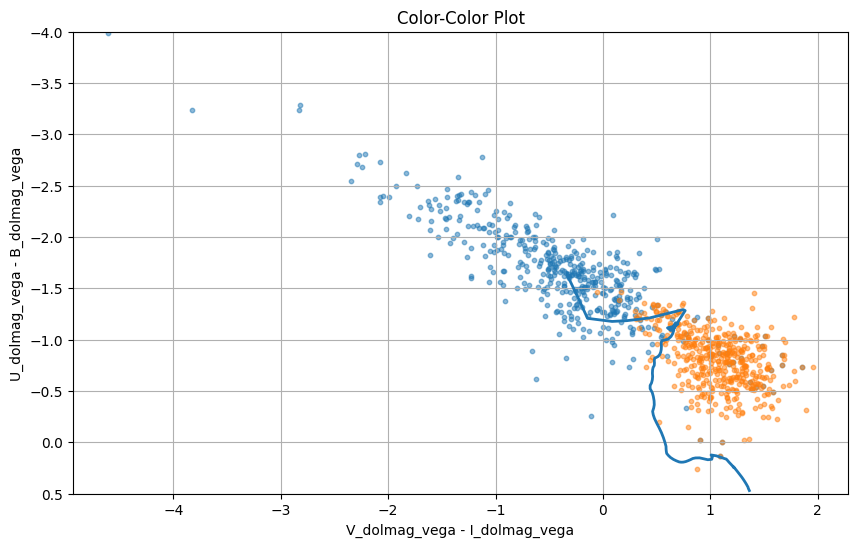

In [11]:
# Calculate color indices
v_i_color = data_reg_tbl['V_dolmag_vega'] - data_reg_tbl['I_dolmag_vega']
u_b_color = data_reg_tbl['U_dolmag_vega'] - data_reg_tbl['B_dolmag_vega']

v_i_color_new = data_reg_tbl['V_dolmag_vega_new'] - data_reg_tbl['I_dolmag_vega_new']
u_b_color_new = data_reg_tbl['U_dolmag_vega_new'] - data_reg_tbl['B_dolmag_vega_new']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5)
plt.scatter(v_i_color,u_b_color, s=10, alpha=0.5)
plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-4)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt.title('Color-Color Plot')
plt.grid(True)
plt.show()

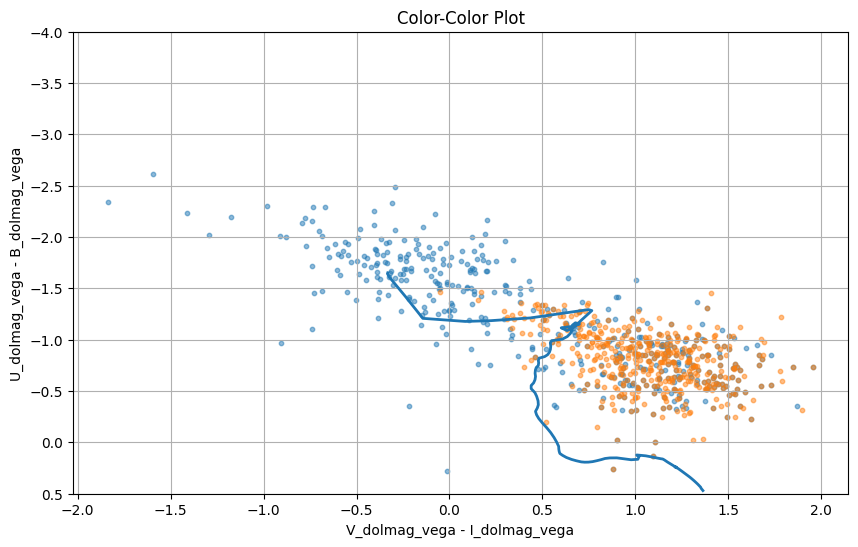

In [12]:
# Calculate color indices
v_i_color = data_tbl['V_dolmag_vega_old'] - data_tbl['I_dolmag_vega_old']
u_b_color = data_tbl['U_dolmag_vega_old'] - data_tbl['B_dolmag_vega_old']

v_i_color_new = data_tbl['V_dolmag_vega'] - data_tbl['I_dolmag_vega']
u_b_color_new = data_tbl['U_dolmag_vega'] - data_tbl['B_dolmag_vega']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5)
plt.scatter(v_i_color,u_b_color, s=10, alpha=0.5)
plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-4)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt.title('Color-Color Plot')
plt.grid(True)
plt.show()

In [24]:
#need to read-in for cigale_pipe3
#reginfo and
#dolphot photometry -> update this file with Chris's measurements then run pipe3

pipefile = google_dir+'PHANGS_IR4_hst_wfc3_ngc4826_v1p3_multi_assoc-nuvselect-ws16pc-main.fits'
pipe_tbl = Table.read(pipefile, format='fits')
pipe_df = pipe_tbl.to_pandas()

pipe_tbl

reg_id,reg_x,reg_y,reg_ra,reg_dec,reg_area,reg_rad,NUV_dolflux_mjy,NUV_dolflux_mjy_err,U_dolflux_mjy,U_dolflux_mjy_err,B_dolflux_mjy,B_dolflux_mjy_err,V_dolflux_mjy,V_dolflux_mjy_err,I_dolflux_mjy,I_dolflux_mjy_err,NUV_dolmag_vega,NUV_dolmag_vega_err,U_dolmag_vega,U_dolmag_vega_err,B_dolmag_vega,B_dolmag_vega_err,V_dolmag_vega,V_dolmag_vega_err,I_dolmag_vega,I_dolmag_vega_err,reg_dolflux_Age_MinChiSq,reg_dolflux_Age_MinChiSq_err,reg_dolflux_Mass_MinChiSq,reg_dolflux_Mass_MinChiSq_err,reg_dolflux_Ebv_MinChiSq,reg_dolflux_Ebv_MinChiSq_err,reg_dolflux_ChiSq_Reduced
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,4149.0,2405.0,194.17805562806927,21.66817000011486,476.4303538512865,12.314726619332893,0.001699323198416626,9.086919555850587e-05,0.002448792838421668,0.00011785189764138915,0.003510068541030133,0.00014423483225357064,0.004255439024845925,0.00014264886757225115,0.011035203967131417,0.00025006095595270494,21.77584818629281,0.05828639499011169,21.733294435804325,0.052457915758978686,22.67420600597371,0.044789999203335304,22.344418383562402,0.03653847810905561,20.866741199111388,0.024699719443364458,9.0,1.0,1505.163895247256,25.87,0.42,0.05,0.9958343790068137
2.0,3342.0,2616.0,194.18761253969285,21.670491999626197,302.79158030910077,9.817410731226436,0.0010433347859270246,4.260296477892622e-05,0.0016330736814443422,5.7148895163149764e-05,0.005535444264920187,9.713486887115406e-05,0.005663302623298223,8.122446898774364e-05,0.010441961224849798,0.00014952195461254367,22.305478933221984,0.044508466731289074,22.17316010253344,0.038144204046408954,22.179613792699634,0.01912710199984003,22.034104890715888,0.015633046136792755,20.926736920619007,0.015608076588123609,127.0,9.0,9202.755559019994,1099.977,0.32,0.02,2.896885274574161
3.0,3261.0,2690.0,194.18857183591226,21.671306363147643,281.2661125146149,9.462017980424912,0.0006758259766431735,4.906139801936609e-05,0.0007751380884075021,6.387827546594067e-05,0.0013176238271084934,0.00010178430321255953,0.0016574576395344798,0.00010093798197396456,0.005099109409546076,0.00018535649442210026,22.77695095020411,0.07912824556808076,22.98222685803005,0.08982569854220758,23.738016399116496,0.0842007318167256,23.36817321920298,0.0663802185511798,21.70495628466836,0.03962232670313987,10.0,0.0,832.7955495341234,135.399,0.47000000000000003,0.05,1.673450940352927
4.0,3015.0,2695.0,194.19148512472734,21.671361212790874,420.4641375856233,11.568832775143976,0.0011849219242417788,6.7858446810657e-05,0.0018088731785123918,9.52661214550275e-05,0.0023869789362683763,0.00011847550837748877,0.0024939497814888763,0.00011661112470877605,0.00663368462185935,0.00021009207888481033,22.167313814001684,0.06242243097235806,22.062154253990716,0.05740594399844965,23.09287353193731,0.05410114943592586,22.924560053006935,0.05096579204441084,21.41930505984761,0.03452084008182122,9.0,1.0,811.0747631819944,16.65,0.37,0.05,2.962116166797271
5.0,2997.0,2750.0,194.19169834185146,21.671966503267118,416.1590440267261,11.50945428499989,0.0013031417966160987,6.827674312782267e-05,0.0014536049274465734,9.726631213729629e-05,0.0028742695660238337,0.00014067593411266536,0.0034663227500032695,0.00013830622950815262,0.008128891163734457,0.00023800613034391952,22.06405896578758,0.05710940298483197,22.299558585812374,0.07293610404574642,22.891176257449196,0.053348081890219536,22.56710681978563,0.0434909848379653,21.19861383879072,0.031914153707981285,11.0,8.0,1344.0303426443497,1453.656,0.41000000000000003,0.04,0.9638718854678884
6.0,3146.0,2767.0,194.18993379662223,21.67215371391705,1485.2572778195226,21.74332253949196,0.02007628603243027,0.00019611378960964344,0.020107947283290635,0.00022870242592032327,0.02285762750817526,0.0003010220854513485,0.021438032694136428,0.0002907921488755078,0.03124234148424092

In [29]:
#Convert Vega mag from data file into mJy
#Create input data file for Cigale

num_markers =len(data_tbl['B_dolflux_mjy'])
gal = 'NGC4826'
pc_scales = ['8','16','32','64']
i = 2
distmpc = 4.41


#--------------
nuv_dolflux_ab_source = conv_vega_mag2ab(data_tbl['NUV_dolmag_vega'],"F275W")
u_dolflux_ab_source = conv_vega_mag2ab(data_tbl['U_dolmag_vega'],"F336W")
b_dolflux_ab_source = conv_vega_mag2ab(data_tbl['B_dolmag_vega'],"F438W")
v_dolflux_ab_source = conv_vega_mag2ab(data_tbl['V_dolmag_vega'],"F555W")
i_dolflux_ab_source = conv_vega_mag2ab(data_tbl['I_dolmag_vega'],"F814W")

nuv_dolflux_mJy_source = conv_ab_mag2mjy(nuv_dolflux_ab_source)
u_dolflux_mJy_source = conv_ab_mag2mjy(u_dolflux_ab_source)
b_dolflux_mJy_source = conv_ab_mag2mjy(b_dolflux_ab_source)
v_dolflux_mJy_source = conv_ab_mag2mjy(v_dolflux_ab_source)
i_dolflux_mJy_source = conv_ab_mag2mjy(i_dolflux_ab_source)

nuv_dolflux_mJy_err = pipe_tbl['NUV_dolflux_mjy_err']
u_dolflux_mJy_err = pipe_tbl['U_dolflux_mjy_err']
b_dolflux_mJy_err = pipe_tbl['B_dolflux_mjy_err']
v_dolflux_mJy_err = pipe_tbl['V_dolflux_mjy_err']
i_dolflux_mJy_err = pipe_tbl['I_dolflux_mjy_err']

nuv_cig_filt = 'hst.wfc3.uvis2.F275W'
u_cig_filt = 'hst.wfc3.uvis2.F336W'
b_cig_filt = 'hst.wfc3.uvis2.F438W'
v_cig_filt = 'hst.wfc3.uvis2.F555W'
i_cig_filt = 'hst.wfc3.uvis2.F814W'
#
#--------------------------------
#Save cigale file
#--------------------------------
#data output for cigale fitting in proper format.
cig_redshift  = np.zeros(num_markers)
cig_distance  = np.full(num_markers, fill_value=distmpc)

t_cig = Table([data_tbl.reg_id,cig_redshift,cig_distance,
        nuv_dolflux_mJy,nuv_dolflux_mJy_err,u_dolflux_mJy,u_dolflux_mJy_err,b_dolflux_mJy,b_dolflux_mJy_err,
        v_dolflux_mJy,v_dolflux_mJy_err,i_dolflux_mJy,i_dolflux_mJy_err],

      names=('id','redshift','distance',nuv_cig_filt, nuv_cig_filt+'_err',u_cig_filt, u_cig_filt+'_err',
          b_cig_filt, b_cig_filt+'_err', v_cig_filt , v_cig_filt+'_err',i_cig_filt , i_cig_filt+'_err'),

      #meta={'ws_data':self.gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })
      meta={'ws_data':gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })


#fits.writeto(outdir+'Dolphot_catalog'+str(int(pc_scales[i]))+'.fits', np.array(t))
df_cig = t_cig.to_pandas()

#replace 0 values with -9999
df_cig.replace([0.0], -9999.0, inplace=True)
df_cig[df_cig < 0] = -9999.0

df_cig['redshift'] = 0.0
cig_file = '{0}_{1}_ws{2}pc_hpfilt{3}_Dolphot_mjy_cigfile.tab'.format(gal,tracer_band,str(int(pc_scales[i])),str(filter_step))
#cig_file = gal+'_'+tracer_band+'_ws'+str(int(pc_scales[i]))+'pc_hpfilt'+str(smooth_step)+'_Dolphot_mjy_cigfile.tab'

#df_cig.to_csv(outdir2+cig_file,sep=' ',index=False)
#--------------------------------

/tmp/ipython-input-1195694115.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tmp/ipython-input-1195694115.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tmp/ipython-input-1195694115.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/tmp/ipython-input-1195694115.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= Tr

AttributeError: 'Table' object has no attribute 'reg_id'

/tmp/ipython-input-1195694115.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)


reg_id,reg_x,reg_y,reg_ra,reg_dec,reg_area,reg_rad,NUV_dolflux_mjy,NUV_dolflux_mjy_err,U_dolflux_mjy,U_dolflux_mjy_err,B_dolflux_mjy,B_dolflux_mjy_err,V_dolflux_mjy,V_dolflux_mjy_err,I_dolflux_mjy,I_dolflux_mjy_err,NUV_dolmag_vega,NUV_dolmag_vega_err,U_dolmag_vega,U_dolmag_vega_err,B_dolmag_vega,B_dolmag_vega_err,V_dolmag_vega,V_dolmag_vega_err,I_dolmag_vega,I_dolmag_vega_err,reg_dolflux_Age_MinChiSq,reg_dolflux_Age_MinChiSq_err,reg_dolflux_Mass_MinChiSq,reg_dolflux_Mass_MinChiSq_err,reg_dolflux_Ebv_MinChiSq,reg_dolflux_Ebv_MinChiSq_err,reg_dolflux_ChiSq_Reduced
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,4149.0,2405.0,194.17805562806927,21.66817000011486,476.4303538512865,12.314726619332893,0.001699323198416626,9.086919555850587e-05,0.002448792838421668,0.00011785189764138915,0.003510068541030133,0.00014423483225357064,0.004255439024845925,0.00014264886757225115,0.011035203967131417,0.00025006095595270494,21.77584818629281,0.05828639499011169,21.733294435804325,0.052457915758978686,22.67420600597371,0.044789999203335304,22.344418383562402,0.03653847810905561,20.866741199111388,0.024699719443364458,9.0,1.0,1505.163895247256,25.87,0.42,0.05,0.9958343790068137
2.0,3342.0,2616.0,194.18761253969285,21.670491999626197,302.79158030910077,9.817410731226436,0.0010433347859270246,4.260296477892622e-05,0.0016330736814443422,5.7148895163149764e-05,0.005535444264920187,9.713486887115406e-05,0.005663302623298223,8.122446898774364e-05,0.010441961224849798,0.00014952195461254367,22.305478933221984,0.044508466731289074,22.17316010253344,0.038144204046408954,22.179613792699634,0.01912710199984003,22.034104890715888,0.015633046136792755,20.926736920619007,0.015608076588123609,127.0,9.0,9202.755559019994,1099.977,0.32,0.02,2.896885274574161
3.0,3261.0,2690.0,194.18857183591226,21.671306363147643,281.2661125146149,9.462017980424912,0.0006758259766431735,4.906139801936609e-05,0.0007751380884075021,6.387827546594067e-05,0.0013176238271084934,0.00010178430321255953,0.0016574576395344798,0.00010093798197396456,0.005099109409546076,0.00018535649442210026,22.77695095020411,0.07912824556808076,22.98222685803005,0.08982569854220758,23.738016399116496,0.0842007318167256,23.36817321920298,0.0663802185511798,21.70495628466836,0.03962232670313987,10.0,0.0,832.7955495341234,135.399,0.47000000000000003,0.05,1.673450940352927
4.0,3015.0,2695.0,194.19148512472734,21.671361212790874,420.4641375856233,11.568832775143976,0.0011849219242417788,6.7858446810657e-05,0.0018088731785123918,9.52661214550275e-05,0.0023869789362683763,0.00011847550837748877,0.0024939497814888763,0.00011661112470877605,0.00663368462185935,0.00021009207888481033,22.167313814001684,0.06242243097235806,22.062154253990716,0.05740594399844965,23.09287353193731,0.05410114943592586,22.924560053006935,0.05096579204441084,21.41930505984761,0.03452084008182122,9.0,1.0,811.0747631819944,16.65,0.37,0.05,2.962116166797271
5.0,2997.0,2750.0,194.19169834185146,21.671966503267118,416.1590440267261,11.50945428499989,0.0013031417966160987,6.827674312782267e-05,0.0014536049274465734,9.726631213729629e-05,0.0028742695660238337,0.00014067593411266536,0.0034663227500032695,0.00013830622950815262,0.008128891163734457,0.00023800613034391952,22.06405896578758,0.05710940298483197,22.299558585812374,0.07293610404574642,22.891176257449196,0.053348081890219536,22.56710681978563,0.0434909848379653,21.19861383879072,0.031914153707981285,11.0,8.0,1344.0303426443497,1453.656,0.41000000000000003,0.04,0.9638718854678884
6.0,3146.0,2767.0,194.18993379662223,21.67215371391705,1485.2572778195226,21.74332253949196,0.02007628603243027,0.00019611378960964344,0.020107947283290635,0.00022870242592032327,0.02285762750817526,0.0003010220854513485,0.021438032694136428,0.0002907921488755078,0.03124234148424092

In [ ]:
		# ------------------------------
		#  Define CIGALE output folder
		# ------------------------------
		outdir = ''
    cigdir = 'out/'
		cigale_file = 'results'
		cigdir_new = outdir+'Cigale_outs/'
		bayes_output_path = cigdir_new+'bayesian_analysis_output/'
		# -------
		#infile_SSP=datadir+'models-block-bc03-0cov.txt'

		# ------------------------------
		#   check for output directory
		# ------------------------------
		if (path.exists(cigdir_new)==True):
		    print('Output directory: '+cigdir_new +' already exists')
		if (path.exists(cigdir_new)==False):
		    os.mkdir(cigdir_new)
		    print("Output Directory '% s' created" % cigdir_new)
		# ------------------------------

In [ ]:
def phangs_cigale_pipe3(self):
		"""Function to fit SEDs, with CIGALE, to associations

		Inputs
		------
		Distance file
		reginfo (pipe1)
		dolphot photometry (pipe2)

		Returns
		-------
		total_runtime: 'float'
			Runtime for step 3 of pipeline

		Notes
		-----
		7/6/22: JWL - config_dict can't be read by pcigale to make pcigale.ini and proceed
				JWL - works if you run 3rd step of Phangs_wshierarchy_main.py though
		7/22/22: JWL - pipe3 works now. Pipeline must be run from appropriate directory for your CIGALE installation to be recognized
		"""
		# ------------------------------
		#  Define CIGALE output folder
		# ------------------------------
		cigdir = 'out/'
		cigale_file = 'results'
		cigdir_new = self.outdir+'Cigale_outs/'
		bayes_output_path = cigdir_new+'bayesian_analysis_output/'
		# -------
		infile_SSP=datadir+'models-block-bc03-0cov.txt'

		# ------------------------------
		#   check for output directory
		# ------------------------------
		if (path.exists(cigdir_new)==True):
		    print('Output directory: '+cigdir_new +' already exists')
		if (path.exists(cigdir_new)==False):
		    os.mkdir(cigdir_new)
		    print("Output Directory '% s' created" % cigdir_new)
		# ------------------------------

		# JWL: Initialize CIGALE stats file
		statfile_name = '{0}{1}_{2}_hpfilt{3}_Cigale_stats.txt'.format(cigdir_new,self.gal,self.tracer_band,self.filter_step)
		#statfile_name = cigdir_new+gal+'_'+tracer_band+'_hpfilt'+filter_step+'_Cigale_stats.txt'
		statfile = open(statfile_name,'w')
		statfile.write(cigdir_new+'\n')
		statfile.write('Galaxy:  {0}\n'.format(self.gal))
		statfile.write('Dolphot file:  {0}\n'.format(self.dolphot_combfile))
		statfile.write('Tracer star band: {0}\n'.format(self.tracer_band))
		statfile.write('Smoothing step: {0}\n'.format(self.filter_step))

		# JWL: Begin tracking runtime
		program_start_time = time.time()

		#---------------------------------
		# check the distance and re-set scale levels
		# Cigale step will fail is there are no regions at a given level.
		pc_scales = ['8','16','32','64']
		n_scales = len(pc_scales)
		if (self.distmpc > 17.0):
		    pc_scales = ['16','32','64']
		    n_scales = len(pc_scales)
		    min_scale_pc = 16 # minimum scale length set in parsecs
		    nlevels = n_scales #number of hierarchy levels to compute

		#-------------------------------------#-------------------------------------#-------------------------------------
		#-------------------------------------#-------------------------------------#-------------------------------------
		#read in model data
		#;;--------
		#;; BC03 models
		#readcol,'models-block-bc03-0cov.txt',
		#format='(i,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d)',bc03id ,bc03F275W_1 ,bc03F275W_2 ,bc03F336W_1 ,bc03F336W_2 ,bc03F435W_acs ,
		#bc03F438W_1 ,bc03F438W_2 ,bc03F555W_ACS ,bc03F555W_1 ,bc03F555W_2 ,bc03F814W_ACS ,bc03F814W_1 ,bc03F814W_1 ,bc03mstar,bc03age
		#;; convert mjy to vega mag
		#infile_SSP='models-block-bc03-0cov.txt'
		#bc03=pd.read_csv(infile_SSP, header=0,converters={'clumpSFRerr':np.float,'age_err':np.float,'mass_err':np.float}, delim_whitespace= True)
		bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)

		#filter_list = ['F336W', 'F435W', 'F555W', 'F814W']
		#ab_zp = [24.52, 25.689, 25.68, 24.99]
		#vega_zp = [23.34, 25.784, 25.71, 24.57]

		filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
		ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
		vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

		bc03_U_ab = -2.5 * np.log10( bc03['F336W_UVIS_CHIP2']* np.power(10.,-29) ) - 48.60
		bc03_U_vega = bc03_U_ab + (vega_zp[0] - ab_zp[0])

		bc03_B_ab = -2.5 * np.log10( bc03['F438W_UVIS_CHIP2']*np.power(10.,-29) ) -48.60
		bc03_B_vega = bc03_B_ab + (vega_zp[1] - ab_zp[1])

		bc03_V_ab = -2.5 * np.log10( bc03['F555W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
		bc03_V_vega = bc03_V_ab + (vega_zp[2] - ab_zp[2])

		bc03_I_ab = -2.5 * np.log10( bc03['F814W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
		bc03_I_vega = bc03_I_ab + (vega_zp[3] - ab_zp[3])
		#;;--------

		#read in combined dolphot + region info table
		#i=0
		statfile.write('pc level, med Age (.25Q,.75Q), med Mass (.25Q,.75Q), med E(B-V) (.25Q,.75Q), med nDolphot (.25Q,.75Q), med NUV dolMag (.25Q,.75Q), med M_V abs(Mag) (.25Q,.75Q) \n')

		for i in range(nlevels):

			#cig_input_file = '{0}_{1}_ws{2}pc_hpfilt{3}_Dolphot_mjy_cigfile.tab'.format(self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))

			#cig_input_file = self.gal+'_'+self.tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(self.filter_step)+'_Dolphot_mjy_cigfile.tab'
			#print(self.outdir2+cig_input_file)
			#cig_input = pd.read_csv(self.outdir2+cig_input_file,sep=' ')
			cig_input_file = self.gal+'_'+self.tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(self.filter_step)+'_Dolphot_mjy_cigfile.tab'
			cig_input = pd.read_csv(self.outdir2+cig_input_file,sep=' ')
			cig_input_col = list(cig_input.columns.values)
			cig_input_filters = cig_input_col[3:13]
			print(cig_input_filters)
			print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
						                                             cig_input_filters[8]])
			datafile_name = '{0}{1}_nuv_ws{2}.fits'.format(self.outdir,self.gal,pc_scales[i])
			#datafile_name =outdir+gal+'_nuv_ws'+pc_scales[i]+'.fits'
			#gal_data_tbl = Table.read(datafile_name, format='fits')

			reginfo_file = '{0}{1}_{2}_ws{3}pc_hpfilt{4}_reginfo.fits'.format(self.outdir,self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))
			#reginfo_file = outdir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_reginfo.fits'
			#reginfo_tbl = fits.getdata(reginfo_file,1)
			reginfo_tbl = Table.read(reginfo_file, format='fits')
			reginfo_df = reginfo_tbl.to_pandas()

			#df = tbl.to_pandas()
			#print(len(df.regID))
			photfile = '{0}{1}_{2}_ws{3}pc_hpfilt{4}_Dolphot.fits'.format(self.outdir2,self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))
			#photfile = outdir2+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_Dolphot'+'.fits'
			phot_tbl = Table.read(photfile, format='fits')
			phot_df = phot_tbl.to_pandas()

			#------------------------------------
			#change fitting to CHIP1
			config_dict = {'data_file': self.outdir2+cig_input_file,
		                       'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustext', 'redshifting'],
		                       'analysis_method': 'pdf_analysis', 'cores': 8,
		                       'bands': cig_input_filters, 'properties': [],
		                       'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
		                                                              'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
		                                                                          14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
		                                                                          32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
		                                                                          71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
		                                                                          147, 158, 169, 182, 196, 210, 226, 243, 261,
		                                                                          281, 302, 324, 349, 375, 403, 433, 465, 500,
		                                                                          537, 577, 621, 667, 717, 770, 828, 890, 956,
		                                                                          1028, 1105, 1187, 1276, 1371, 1474, 1584,
		                                                                          1702, 1829, 1966, 2113, 2271, 2440, 2623,
		                                                                          2819, 3029, 3255, 3499, 3760, 4041, 4343,
		                                                                          4667, 5015, 5390, 5793, 6225, 6690, 7190,
		                                                                          7727, 8304, 8925, 9591, 10308, 11077,
		                                                                          11905, 12794, 13750],
		                                                              'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
		                                                  'bc03': {'imf': [1], 'metallicity': [0.02], 'separation_age': [10]},
		                                                  'dustext': {'E_BV': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
		                                                                           0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15,
		                                                                           0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23,
		                                                                           0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31,
		                                                                           0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37,
		                                                                           0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43,
		                                                                           0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5,
		                                                                           0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001,
		                                                                           0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
		                                                                           0.67, 0.68, 0.6900000000000001, 0.7000000000000001,
		                                                                           0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
		                                                                           0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84,
		                                                                           0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93,
		                                                                           0.9400000000000001, 0.9500000000000001, 0.96, 0.97,
		                                                                           0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06,
		                                                                           1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001,
		                                                                           1.1400000000000001, 1.1500000000000001, 1.16, 1.17,
		                                                                           1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
		                                                                           1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36,
		                                                                           1.37, 1.3800000000000001, 1.3900000000000001,
		                                                                           1.4000000000000001, 1.41, 1.42, 1.43, 1.44, 1.45,
		                                                                           1.46, 1.47, 1.48, 1.49, 1.5], 'Rv': [3.1], 'law': [0],
		                                                                  'filters': cig_input_filters[0]+' & '+cig_input_filters[2]+' & '+cig_input_filters[4]+' & '+
		                                                                  cig_input_filters[6]+' & '+cig_input_filters[8]},
		                                                  'redshifting': {'redshift': [0.0]}},
		                       'analysis_params': {'variables': ['stellar.age', 'stellar.m_star', 'attenuation.E_BV', 'sfh.age'],
		                                               'bands': [cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
		                                                             cig_input_filters[8]],
		                                                             'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': False,
		                                               'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}
			#-------------------------------------#-------------------------------------#-------------------------------------
			#
			pdf = PdfAnalysis()
			pdf.process(config_dict)
			#-------------------------------------#-------------------------------------

			#copy cigale output to data output dir.
			#cigale_new_file = cigdir_new+gal+'_ws'+scales[i]+'_cig_results'

			cigale_new_file = cigdir_new+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_cig_results'

			#os.system('cp '+cigdir+cigale_file+'.fits '+cigale_new_file+'.fits')
			#os.system('cp '+cigdir+cigale_file+'.txt '+cigale_new_file+'.txt')
			#os.system('cp '+cigdir+'observations.txt '+cigdir_new )
			#os.system('cp '+cigdir+'observations.fits '+cigdir_new )


			#in Myr( *10^6) for ages
			#in units of Msolar

			#-------------------------------------#-------------------------------------
			#        Read in cigale data
			#cigale=fits.getdata(cigdir+cigale_file+'.fits')
			#cigale.dtype

			cigale_tbl = Table.read(cigdir+cigale_file+'.fits', format='fits')
			cigale_df = cigale_tbl.to_pandas()

			#-------------------------------------#-------------------------------------#-------------------------------------
			#sinan ERROR code:
			age_error, mass_error, ebv_error = [], [], []

			for sed_object_index, sed_object_regID in enumerate(reginfo_df['regID'].values):
				#print(sed_object_index, sed_object_regID)

				age_file = 'out/'+str(sed_object_regID)+'_sfh.age_chi2-block-0.npy'
				mass_file = 'out/'+str(sed_object_regID)+'_stellar.m_star_chi2-block-0.npy'
				ebv_file = 'out/'+str(sed_object_regID)+'_attenuation.E_BV_chi2-block-0.npy'

				if (path.exists(age_file) & path.exists(mass_file) & path.exists(ebv_file)):
					models, pdf, generated_red_chi2 = self.read_data(age_file, mass_file, ebv_file, return_red_chi2=True)
					age_1sigma, mass_1sigma, ebv_1sigma = self.calc_chi2_uncertainty(models[:, 0], models[:, 1], models[:, 2], generated_red_chi2)

					age_error.append(age_1sigma)
					mass_error.append(mass_1sigma)
					ebv_error.append(ebv_1sigma)
				else:
					age_error.append(np.NAN)
					mass_error.append(np.NAN)
					ebv_error.append(np.NAN)

			"""KEEP MASS-AGE-EBV WITH 3 SIGNIFICANT FIGURES"""
			cigale_df['reg_dolflux_Age_MinChiSq_err'] = np.round(age_error, 3)
			cigale_df['reg_dolflux_Mass_MinChiSq_err'] = np.round(mass_error, 3)
			cigale_df['reg_dolflux_Ebv_MinChiSq_err'] = np.round(ebv_error, 3)

			#-----------
			#save cigale output to data table
			#-----------
			cigale_df.to_csv(cigale_new_file+'.csv')
			new_cigale_tbl = Table.from_pandas(cigale_df)
			new_cigale_tbl.write(cigale_new_file+'.fits',overwrite=True)

			#-----------
			shutil.move(cigdir+'observations.txt',cigdir_new+'observations.txt')
			shutil.move(cigdir+'observations.fits',cigdir_new+'observations.fits')

			#os.system('cp '+cigdir+cigale_file+'.fits '+cigale_new_file+'.fits')
			#os.system('cp '+cigdir+cigale_file+'.txt '+cigale_new_file+'.txt')
			#os.system('cp '+cigdir+'observations.txt '+cigdir_new )
			#os.system('cp '+cigdir+'observations.fits '+cigdir_new )

			#-------------------------------------#-------------------------------------#-------------------------------------
			#"""Call to Jordan Turner's Bayesian Priors analysis here"""

			#   ---------------      ADD Bayesian CODE HERE      ---------------   #

			#-------------------------------------#-------------------------------------#-------------------------------------
			#If using mac or linux can remove cigale directory when done.
			# Will NOT run on a windows OS
			#remove cigale directory
			os.system('rm -r '+cigdir)

			#------------------------------------    #------------------------------------    #------------------------------------
			g_mass = (np.log10(cigale_tbl['best.stellar.m_star']) > 0 )
			Mv = phot_df.v_dolmag - self.dist_mod

			#Check for Inf
			Mv[(Mv==np.inf)] = np.NAN
			phot_df.nuv_dolmag[(phot_df.nuv_dolmag==np.inf)] = np.NAN

			print(pc_scales[i]+'pc, '+str((np.nanmedian(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6))) )
				+' ('+str((np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .25)))+','
				+str((np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .75)))+') &'
				+str((np.nanmedian(np.log10(cigale_df['best.stellar.m_star'][g_mass]))))
				+' ('+str((np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .25)))+','+str((np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .75)))+') &'
				+str((np.nanmedian(cigale_df['best.attenuation.E_BV'][g_mass])))
				+' ('+str((np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .25)))+','+str((np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .75)))+') &'
				+str((np.nanmedian(phot_df.ndolphot)))+' ('+str((np.nanquantile(phot_df.ndolphot, .25)))+','+str((np.nanquantile(phot_df.ndolphot, .75)))+') &'
				+str((np.nanmedian(phot_df.nuv_dolmag)))+' ('+str((np.nanquantile(phot_df.nuv_dolmag, .25)))+','+str((np.nanquantile(phot_df.nuv_dolmag, .75)))+') &'
				+str((np.nanmedian(Mv)))+' ('+str((np.nanquantile(Mv, .25)))+','+str((np.nanquantile(Mv, .75)))+') '
				)

			#------------------------------------    #------------------------------------    #------------------------------------
			#       Save stats
			#------------------------------------
			#g_mass = (np.log10(cigale_tbl['best.stellar.m_star']) > 0 )
			#Mv = phot_df.v_dolmag - dist_mod
			# med reddening, ndolphot,med '+tracer_band+'(.25Q,.75Q)   \n')
			statfile.write(pc_scales[i]+'pc, '+str(self.round_sig(np.nanmedian(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6))) )
						+' ('+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .25)))+','
						+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .75)))+') &'
						+str(self.round_sig(np.nanmedian(np.log10(cigale_df['best.stellar.m_star'][g_mass]))))
						+' ('+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .25)))+','
						+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .75)))+') &'
						+str((np.nanmedian(cigale_df['best.attenuation.E_BV'][g_mass])))
						+' ('+str(np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .25))
						+','+str(np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .75))+') &'
						+str(self.round_sig(np.nanmedian(phot_df.ndolphot)))+' ('+str(self.round_sig(np.nanquantile(phot_df.ndolphot, .25)))
						+','+str(self.round_sig(np.nanquantile(phot_df.ndolphot, .75)))+') &'
						+str(self.round_sig(np.nanmedian(phot_df.nuv_dolmag)))+' ('+str(self.round_sig(np.nanquantile(phot_df.nuv_dolmag, .25)))
						+','+str(self.round_sig(np.nanquantile(phot_df.nuv_dolmag, .75)))+') &'
						+str(self.round_sig(np.nanmedian(Mv)))+' ('+str(self.round_sig(np.nanquantile(Mv, .25)))+','+str(self.round_sig(np.nanquantile(Mv, .75)))+') '
						+' \n' )

			#------------------------------------    #------------------------------------    #------------------------------------
			#Save combined datafile
			#--------------------------------
			t_comb =Table([reginfo_df['regID'],reginfo_df['peak_xpos'],reginfo_df['peak_ypos'],reginfo_df['peak_ra'],reginfo_df['peak_dec'],reginfo_df['area_pc'],reginfo_df['rad_pc'],
							phot_df.nuv_dolflux_mjy, phot_df.nuv_dolflux_mjy_err ,phot_df.u_dolflux_mjy,phot_df.u_dolflux_mjy_err, phot_df.b_dolflux_mjy, phot_df.b_dolflux_mjy_err,
							phot_df.v_dolflux_mjy, phot_df.v_dolflux_mjy_err, phot_df.i_dolflux_mjy, phot_df.i_dolflux_mjy_err,
							phot_df.nuv_dolmag, phot_df.nuv_dolmagUnc, phot_df.u_dolmag, phot_df.u_dolmagUnc, phot_df.b_dolmag, phot_df.b_dolmagUnc,
							phot_df.v_dolmag, phot_df.v_dolmagUnc, phot_df.i_dolmag, phot_df.i_dolmagUnc,
							cigale_df['best.stellar.age_m_star'], cigale_df['reg_dolflux_Age_MinChiSq_err'],
							cigale_df['best.stellar.m_star'], cigale_df['reg_dolflux_Mass_MinChiSq_err'],
							cigale_df['best.attenuation.E_BV'], cigale_df['reg_dolflux_Ebv_MinChiSq_err'], cigale_df['best.reduced_chi_square']
		                        ],
							names=('reg_id','reg_x','reg_y','reg_ra','reg_dec','reg_area','reg_rad',
		                             'NUV_dolflux_mjy','NUV_dolflux_mjy_err','U_dolflux_mjy','U_dolflux_mjy_err','B_dolflux_mjy','B_dolflux_mjy_err',
		                             'V_dolflux_mjy','V_dolflux_mjy_err','I_dolflux_mjy', 'I_dolflux_mjy_err',
		                             'NUV_dolmag_vega','NUV_dolmag_vega_err','U_dolmag_vega','U_dolmag_vega_err',
		                             'B_dolmag_vega','B_dolmag_vega_err','V_dolmag_vega','V_dolmag_vega_err',
									 'I_dolmag_vega','I_dolmag_vega_err',
		                             'reg_dolflux_Age_MinChiSq','reg_dolflux_Age_MinChiSq_err',
		                             'reg_dolflux_Mass_MinChiSq','reg_dolflux_Mass_MinChiSq_err',
		                             'reg_dolflux_Ebv_MinChiSq', 'reg_dolflux_Ebv_MinChiSq_err','reg_dolflux_ChiSq_Reduced'),
							meta={'ws_data':gal+' tracer band:'+tracer_band+'scale level [pc]:'+pc_scales[i] })

			combfile = '{0}_phangshst_associations_{1}_ws{2}pc_v1'.format(self.gal,self.tracer_band,pc_scales[i])
			#combfile = gal+'_phangshst_associations_'+tracer_band+'_ws'+pc_scales[i]+'pc_v1'
			#os.system('rm '+outdir2+photfile+'.fits')
			fits.writeto(self.outdir2+combfile+'.fits', np.array(t_comb),overwrite=True)
			df_comb = t_comb.to_pandas()
			df_comb.to_csv(self.outdir2+combfile+'.csv')
			print(self.outdir2+combfile+'.csv written' )
			#------------------------------------

			#--------------------------------
		statfile.close()
		#--------------------------------
		print('%s --- Cigale(pipe3) finished...' % gal)

		total_runtime = (time.time() - program_start_time)/60.0
		print("%s --- Total time --- %.2f seconds (%.2f minutes) ---" % (gal,time.time() - program_start_time,total_runtime))

		return(np.round(total_runtime,2))